In [1]:
import shutup
import msprime
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [3]:
## CONSTANTS
seed = 123117
num_reps = 1
sp_name = "HomSap"
chrom = None
length = 10_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows=100
HomSap_1Mb_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "test/raw/", chrom, length, sample_size, n_workers=512)
dead_zone = [400_000, 600_000]

In [4]:
breaks = np.linspace(0, HomSap_1Mb_OOA.contig.length, num_windows+1)

In [5]:
HomSap_1Mb_OOA.contig.recombination_map = msprime.RateMap(position=[0]+dead_zone+[1_000_000], rate=[1e-8, 0,1e-8])
run_sims(HomSap_1Mb_OOA)

In [6]:
# Importing our dataset
dataset = TreeSequencesDataset("test/", HomSap_1Mb_OOA.sims_path,seeds=HomSap_1Mb_OOA.seed_array, y_name="windowed-diversity")
compute_ys(dataset, windowed_div_from_ts, "windowed-diversity", num_windows=num_windows, n_workers=256)


Let's compute the node embeddings before and after training (trained on pi prediction)

In [7]:
encoder = BiGCNEncoder(breaks, device, 1, 1)
out_un = encoder(dataset[0])
out_un = out_un.detach().numpy()
print(encoder.state_dict())
encoder.load_state_dict(torch.load("trained_encoder.pt"))
print(encoder.state_dict())

OrderedDict([('lin1.weight', tensor([[ 0.0218],
        [-0.6241]])), ('lin1.bias', tensor([-0.8880, -0.3593])), ('conv.bias', tensor([0., 0.])), ('conv.lin.weight', tensor([[-0.5249, -0.4526],
        [-1.0846, -0.7482]])), ('conv_f.bias', tensor([0., 0.])), ('conv_f.lin.weight', tensor([[-0.3982,  0.0539],
        [ 0.9331,  0.5397]])), ('conv_b.bias', tensor([0., 0.])), ('conv_b.lin.weight', tensor([[ 0.1039,  0.7525],
        [-0.3408,  0.1833]])), ('batch_norm.weight', tensor([1., 1.])), ('batch_norm.bias', tensor([0., 0.])), ('batch_norm.running_mean', tensor([ 627.5007, 1026.3447])), ('batch_norm.running_var', tensor([ 6483646.5000, 17344488.0000])), ('batch_norm.num_batches_tracked', tensor(1)), ('batch_norm_f.weight', tensor([1., 1.])), ('batch_norm_f.bias', tensor([0., 0.])), ('batch_norm_f.running_mean', tensor([-0.0017, -0.0129])), ('batch_norm_f.running_var', tensor([  2.1863, 111.6883])), ('batch_norm_f.num_batches_tracked', tensor(100)), ('batch_norm_b.weight', tensor([1

In [8]:
out_tr = encoder(dataset[0])
out_tr = out_tr.detach().numpy()

In [9]:
ts = tskit.load(dataset.raw_file_names[0])
edges = ts.tables.edges
nodes_age = np.zeros(ts.num_nodes)
nodes_overlap = np.zeros(ts.num_nodes)
get_node_span = lambda nid, edges: [np.min(edges[np.logical_or(edges.child==nid,edges.parent==nid)].left), 
             np.max(edges[np.logical_or(edges.child==nid,edges.parent==nid)].right)]

In [10]:
def get_intersection_overlap(a, b):
    """
    Returns the intersection over union of two bounding boxes.
    Note, lower and upper bounds intersect exactly, it is considered not an intersection.

    ref:
        - https://stackoverflow.com/a/2953979/1601580
    """
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

In [11]:
for node in ts.nodes():
    nid = node.id
    node_span = get_node_span(nid, edges)
    op = get_intersection_overlap(node_span, dead_zone)/np.diff(node_span)[0]
    nodes_age[nid] = node.time
    nodes_overlap[nid] = op


Let's see how the relationship between the two dimensions the encoder outputs (blue untrained encoder, red trained encoder).

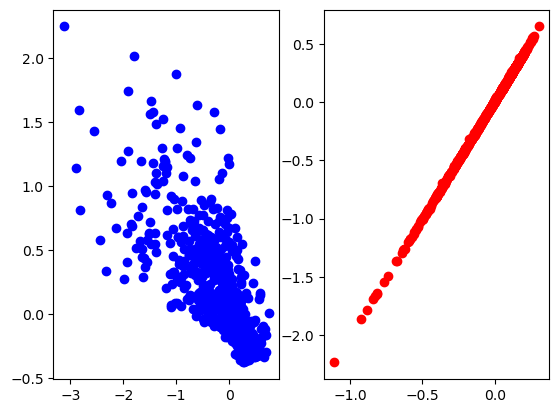

In [12]:
plt.figure()
plt.subplot(121)
plt.plot(out_un[:,1], out_un[:,0], 'bo')
plt.subplot(122)
plt.plot(out_tr[:,1], out_tr[:,0], 'ro')
plt.show()

Now checking the correlation between node time and the node embeddings. See how they are highly correlated, but less so in the case of younger nodes.

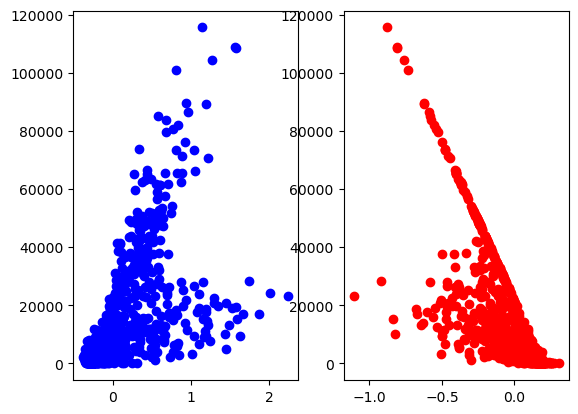

In [13]:
plt.figure()
plt.subplot(121)
plt.plot(out_un[:,0], nodes_age, 'bo')
plt.subplot(122)
plt.plot(out_tr[:,1], nodes_age, 'ro')
plt.show()

Correlation between the overlap of the node span with the dead zone in recombination rate and the node embeddings.

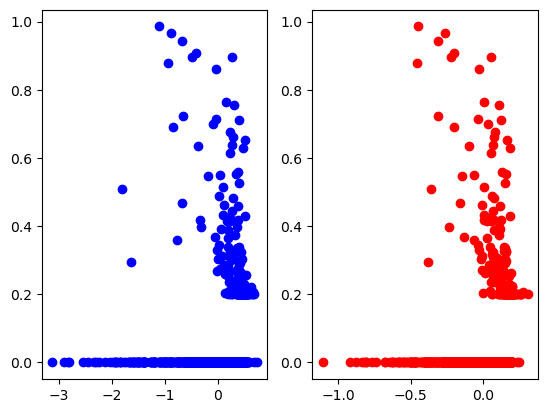

In [14]:
plt.figure()
plt.subplot(121)
plt.plot(out_un[:,1], nodes_overlap, 'bo')
plt.subplot(122)
plt.plot(out_tr[:,1], nodes_overlap, 'ro')
plt.show()

Now just confirming there is no correlation between node age and node overlap with dead zone

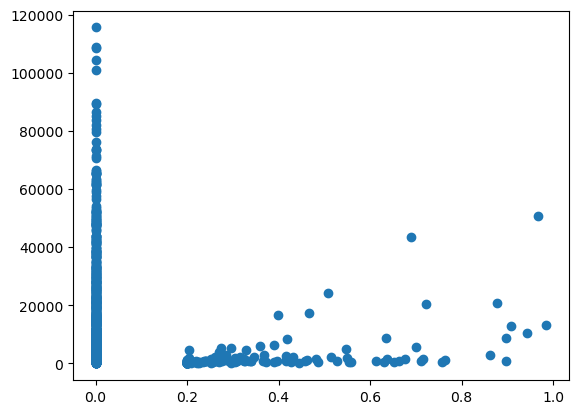

In [15]:
plt.plot(nodes_overlap, nodes_age, 'o')